# Segmentación de clientes

👋 A continuación se hace la segmentación de clientes a partir de un set de datos de 2000 entradas correspondiente a la compra de diferentes artículos por parte de diferentes clientes.

Los datos dentro del dataset son:

----

**ID	numerical	Integer	Shows a unique identificator of a customer**
				
**Sex	categorical	{0,1}	Biological sex (gender) of a customer. In this dataset there are only 2 different options.**	
		0	male	
		1	female	
				
**Marital status	categorical	{0,1}	Marital status of a customer.**

0	single	
1	non-single (divorced / separated / married / widowed)	
				
**Age	numerical	Integer	The age of the customer in years, calculated as current year minus the year of birth of the customer at the time of creation of the dataset**

18	Min value (the lowest age observed in the dataset)	
76	Max value (the highest age observed in the dataset)	
				
**Education	categorical	{0,1,2,3}	Level of education of the customer**
		
0	other / unknown	
1	high school	
2	university	
3	graduate school	
				
**Income	numerical	Real	Self-reported annual income in US dollars of the customer.**

35832	Min value (the lowest income observed in the dataset)	
309364	Max value (the highest income observed in the dataset)	
				
**Occupation	categorical	{0,1,2}	Category of occupation of the customer.**

0	unemployed / unskilled	
1	skilled employee / official	
2	management / self-employed / highly qualified employee / officer	
				
**Settlement size	categorical	{0,1,2}	The size of the city that the customer lives in.**

0	small city	
1	mid-sized city	
2	big city

----

## Objetivo

Segmentar clientes en base a ciertas características.

Para esto utilizaremos *Kmeans* y *Principal Component Analysis*

In [1]:
## importamos librerías y paquetes
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.preprocessing import StandardScaler

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

from sklearn.decomposition import PCA

import pickle

In [2]:
#importando datos

df = pd.read_csv("datasets/segmentation_data.csv", index_col = 0)
df.head()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
ID,,,,,,,
100000001,0,0,67,2,124670,1,2
100000002,1,1,22,1,150773,1,2
100000003,0,0,49,1,89210,0,0
100000004,0,0,45,1,171565,1,1
100000005,0,0,53,1,149031,1,1


In [3]:
## Resumen del dataframe
df.describe()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
count,2000.000000,2000.000000,2000.000000,2000.00000,2000.000000,2000.000000,2000.000000
mean,0.457000,0.496500,35.909000,1.03800,120954.419000,0.810500,0.739000
std,0.498272,0.500113,11.719402,0.59978,38108.824679,0.638587,0.812533
min,0.000000,0.000000,18.000000,0.00000,35832.000000,0.000000,0.000000
25%,0.000000,0.000000,27.000000,1.00000,97663.250000,0.000000,0.000000
50%,0.000000,0.000000,33.000000,1.00000,115548.500000,1.000000,1.000000
75%,1.000000,1.000000,42.000000,1.00000,138072.250000,1.000000,1.000000
max,1.000000,1.000000,76.000000,3.00000,309364.000000,2.000000,2.000000


Debemos tener en cuenta que la tabla anterior no es muy informativa para variables categóricas.

- En el caso de categorías del tipo 0 o 1 la media nos dice la proporción. Por ejemplo, vemos un 45.7% de mujeres en el set de datos.
- No podemos decir nada acerca de las variables educación, ocupación y lugar de asentamiento (settlement).

### Correlación

Ahora vamos a ver cómo se correlacionan estas variables. Siempre es bueno buscar correlaciones entre las variables para ver si existe algún tipo de relación entre ellas. Esto es útil para entrenar modelos de ML.

En general, se utiliza la correlación de Pearson, la cual nos da inforamción de correlación *lineal*. Podríamos tener variables que se correlacionan de una forma no lineal, y deberíamos usar otra medida.

In [4]:
df.corr()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
Sex,1.000000,0.566511,-0.182885,0.244838,-0.195146,-0.202491,-0.300803
Marital status,0.566511,1.000000,-0.213178,0.374017,-0.073528,-0.029490,-0.097041
Age,-0.182885,-0.213178,1.000000,0.654605,0.340610,0.108388,0.119751
Education,0.244838,0.374017,0.654605,1.000000,0.233459,0.064524,0.034732
Income,-0.195146,-0.073528,0.340610,0.233459,1.000000,0.680357,0.490881
Occupation,-0.202491,-0.029490,0.108388,0.064524,0.680357,1.000000,0.571795
Settlement size,-0.300803,-0.097041,0.119751,0.034732,0.490881,0.571795,1.000000


Generemos un *heatmap*.

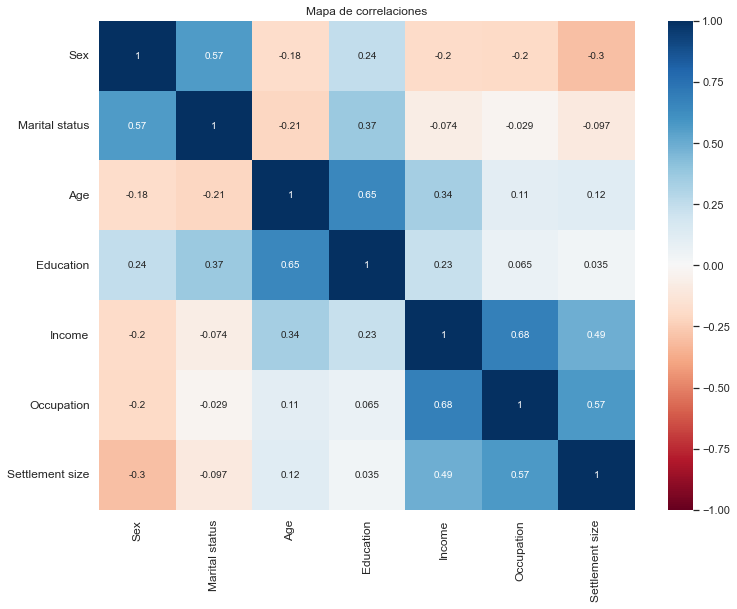

In [5]:
plt.figure(figsize = (12,9))
s = sns.heatmap(df.corr(), annot = True, cmap = "RdBu",
               vmin = -1, vmax = 1)

s.set_yticklabels(s.get_yticklabels(), rotation = 0, fontsize = 12)
s.set_xticklabels(s.get_xticklabels(), rotation = 90, fontsize = 12)
plt.title("Mapa de correlaciones")
plt.show()

Algunas variables se correlacionan positivamente, hasta casi un 70%. Por ejemplo, *income* y *Ocupación*, lo cual tiene sentido ya que es de esperarse que el ingreso esté relacionado al tipo de ocupación que la persona realice.

### Visualizando datos crudos

Veamos algunos datos en un gráfico de dispersión para las variables *Income* y *Age*.

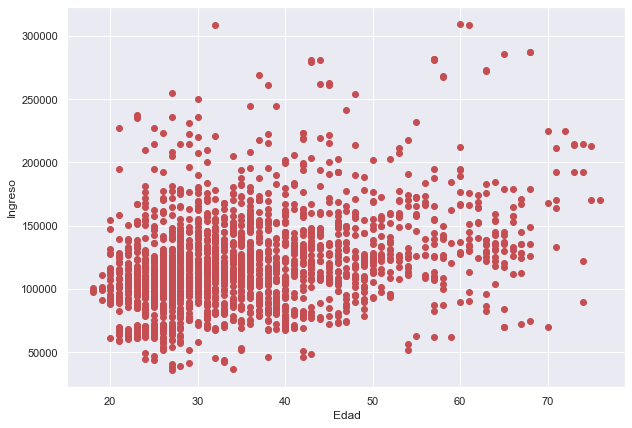

In [6]:
fig, ax = plt.subplots(figsize=(10,7))

ax.set_xlabel("Edad")
ax.set_ylabel("Ingreso")
ax.set_title("")
ax.scatter(df["Age"], df["Income"], color = "r")
# ax.scatter(df.iloc[:,2], df.iloc[:,4]) #forma equivalente

plt.show()

### Estandarizando datos

Sabemos que los modelos son susceptibles a los rangos de nuestros datos y por lo tanto, debemos siempre considerar esto antes de entrenar alguno con nuestros datos.

Una forma muy habitual de hacer esto es usando [sklearn.preprocessing.StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html), veamos.

In [7]:
scaler = StandardScaler()

df_std = scaler.fit_transform(df)

## Dendograma

Vamos a generar un *Dendograma* el cual es una forma de realizar clusters jerárquicos o hereditarios utilizando el método [linkage](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html) de Scipy.

In [8]:
cluster_jer = linkage(df_std, method = "ward") #cluster por jerarquía

Debemos notar que hemos usado los datos *estandarizados* para generar los cluster.

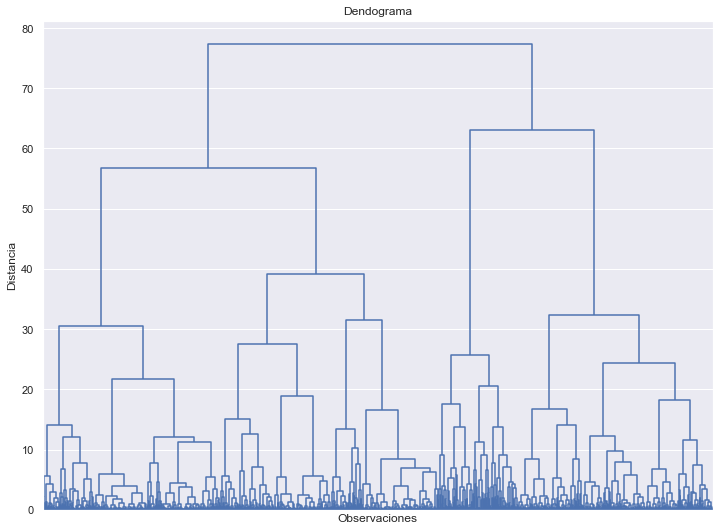

In [9]:
fig, ax = plt.subplots(figsize = (12,9))

ax.set_title("Dendograma")
ax.set_xlabel("Observaciones")
ax.set_ylabel("Distancia")

dendrogram(cluster_jer, show_leaf_counts = False, no_labels = True,
          color_threshold = False)

plt.show()

### Regla báscia para definir la cantidad de cluster

Ahora bien, ¿cuántos cluster podemos/debemos elegir a partir del gráfico anterior?

En general existe una regla general o "rule of thumbs" la cual dice,

> Partimos desde arriba hacia abajo buscando la línea vertical más larga y vemos si le cruzan o no líneas horizontales. Las líneas horizontales se forman en la unión de dos observaciones.

A modo de ejemplo, en las primeras dos líneas verticales, la de la izquierda es la más larga, no obstante, es *cortada* por la linea horizontal (que sale de la vertical derecha).

Siguiendo para abajo, la única línea vertical que no es cortada por líneas horizontales es la segunda (contando de izquierda a derecha). Por lo tanto, podríamos definir 4 clústers.

Ahora bien, el método *[dendrogram](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html)* tiene por defecto *color_threshold = True*. Lo que hace esto es *colorear* una cantidad *k* de clusters. La documentación dice,

>For brevity, let  be the color_threshold. Colors all the descendent links below a cluster node  the same color if  is the first node below the cut threshold . All links connecting nodes with distances greater than or equal to the threshold are colored with de default matplotlib color 'C0'. If  is less than or equal to zero, all nodes are colored 'C0'. If color_threshold is None or ‘default’, corresponding with MATLAB(TM) behavior, the threshold is set to 0.7*max(Z[:,2]).

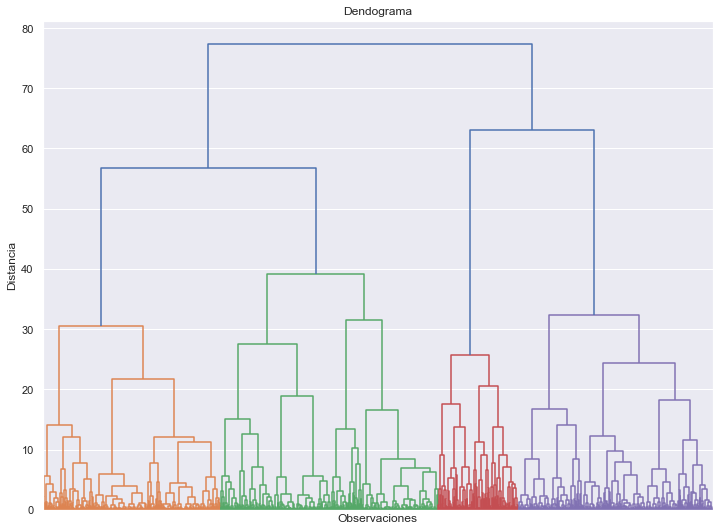

In [10]:
fig, ax = plt.subplots(figsize = (12,9))

ax.set_title("Dendograma")
ax.set_xlabel("Observaciones")
ax.set_ylabel("Distancia")

dendrogram(cluster_jer, show_leaf_counts = False, no_labels = True)

plt.show()

## Cluster usando *K-means*

El algorítmo de Kmeans es muy conocido y es la puerta de entrada de los algoritmos de agrupamiento. Ahora bien, uno de las cuestiones que debemos resolver cuando hacemos agrupamientos es determinar la *cantidad de grupos* o clusters que podemos formar de nuestros datos.

Existe una regla conocida como *[Elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)#:~:text=In%20cluster%20analysis%2C%20the%20elbow,number%20of%20clusters%20to%20use.)* el cual nos permite determinar la cantidad de clusters óptimos en base a nuestro dataset.

Este método utiliza los valores de la *inercia* obtenidos cuando aplicamos K-means a diferente número de clusters (desde 1 a k Clusters), siendo la inercia la *suma de las distancias al cuadrado de cada objeto del cluster a su centroide*. Esto también se conoce en inglés cómo *within clsuters sum of squares* o *WCSS*, dado por,

$$ Inercia = \sum_{j=1}^k \sum_{x_i \in cluster  j}^N \left|\left| x_i - \mu_j \right|\right|^2$$

Vamos a implementar un loop para generar 10 cluster, partiendo de $k=1...10$ para aplicar la regla del codo.

In [11]:
wcss = []

for k in range(1,11):
    kmeans = KMeans(n_clusters = k, init = "k-means++", random_state = 42)
    kmeans.fit(df_std) #entrenamos con los datos estandarizados
    wcss.append(kmeans.inertia_)

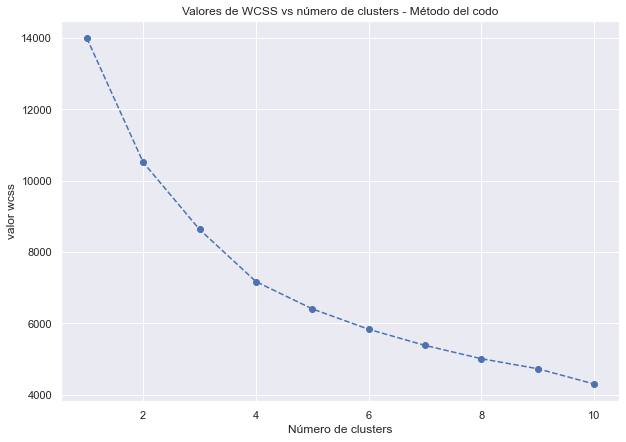

In [12]:
plt.figure(figsize = (10,7))
plt.xlabel("Número de clusters")
plt.ylabel("valor wcss")
plt.title("Valores de WCSS vs número de clusters - Método del codo")
plt.plot(range(1,11), wcss, marker = "o", linestyle = "--")
plt.show()

La idea detrás del método del codo es buscar el punto donde los datos dejan de caer abruptamente para empezar a caer de una forma suave.

En el gráfico anterior podríamos decir que cuando $k=4$ tenemos el codo y por lo tanto, vamos a agrupar nuestros datos en 4 grupos.

Esto concuerda con el dendograma visto anteriormente.

#### Agrupando datos

Vamos a generar una intancia de *KMeans* de cuatro grupos y la entrenaremos con nuestros datos estandarizados, luego agruparemos los datos para analizar los resultados obtenidos.

In [13]:
kmeans = KMeans(n_clusters = 4, init = "k-means++", random_state = 42)

Entrenamos el modelo

In [14]:
kmeans.fit(df_std)

KMeans(n_clusters=4, random_state=42)

**Etiquetas**

Una vez que hemos entrenado el modelo, el mismo genera una etiqueta a cada instancia dentro del set de datos. Las etiquetas se alojan en la variable *labels_*.

Veamos.

In [15]:
kmeans.labels_[:40]

array([0, 2, 1, 3, 3, 1, 3, 3, 0, 3, 2, 2, 2, 1, 2, 2, 1, 3, 0, 3, 3, 3,
       1, 3, 3, 1, 1, 0, 3, 0, 3, 3, 3, 1, 2, 1, 3, 3, 3, 3])

Ahora bien, podemos agregar una columna a nuestro set de datos original y agruparlos en base a estas etiquetas para realizar diferentes tipos de análisis.

Ahora vamos a realizar simplemente el cálculo de los valores medios de cada atributo agrupando en base a las etiquetas.

In [16]:
df_analisis = df.copy() #generamos una copia de los datos

df_analisis["Segmentos por kmeans"] = kmeans.labels_

Agrupamos

In [17]:
df_segmentado = df_analisis.groupby(df_analisis["Segmentos por kmeans"]).mean()
df_segmentado

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
Segmentos por kmeans,,,,,,,
0,0.501901,0.692015,55.703422,2.129278,158338.422053,1.129278,1.110266
1,0.352814,0.019481,35.577922,0.746753,97859.852814,0.329004,0.043290
2,0.853901,0.997163,28.963121,1.068085,105759.119149,0.634043,0.422695
3,0.029825,0.173684,35.635088,0.733333,141218.249123,1.271930,1.522807


#### Breve análisis 📚

**Gruopo 0: Personas acomodadas**

- Podemos ver que se compone de casi la misma proporción de hombres y de mujeres.
- La edad promedio es de casi 56 años. Es el segmento mas viejo de los cuatro.
- Más del 2/3 está en alguna relación.
- Es el segmento con el nivel de educación más alto.
- Es el segmento con el nivel de ingresos más alto.

Podemos llamar al grupo 0 como *personas acomodadas*.

**Grupo 1: Baja oportunidad**

- El 2/3 es hombre.
- La mayoría de las personas dentro de ese segmento está soltera.
- La edad promedio es de 36 años.
- El nivel de educación, de ocupación y el nivel de ingresos son los más bajos de los 4 grupos.
- Este grupo vive en pequeñas ciudades.

Podemos llamar a este grupo como *baja oportunidad*

**Grupo 2 Estándar**:

- Mayormente formado por mujeres.
- Casi el 100% está en alguna relación.
- Es el grupo más joven.
- Posee un nivel de educación medio, al igual que el de ingreso.
- Poco más del 2/3 de las personas de este grupo posee trabajo.
- Podemos ver que las personas dentro de este posible segmento viven repartidas entre ciudades pequeñas a ciudades grandes.

Llamaremos a este grupo *Estándar*.

**Grupo 3: enfocados en trabajar**

- Prácticamente formado por hombres.
- Sólo un 17% está en alguna relación.
- La edad promedio es de 35.63 años.
- Podemos notar un nivel relativamente bajo en educación, pero un nivel de ingresos relativamente alto.
- Poseen el nivel de ocupación en trabajo más alto, este es un dato importante porque nos da la pauta de que es un grupo de personas que se enfoca en su trabajo por encima de otra cosa, es decir, en recaudar guita.
- Este grupo también vive mayoritariamente en ciudades grandes.

Llamaremos a este grupo *enfocados en trabajar*.

#### Proporciones de cada grupo

Vamos a ver las proporciones de cada grupo.

In [18]:
df_segmentado["N Obs"] = df_analisis[["Segmentos por kmeans","Sex"]].groupby("Segmentos por kmeans").count()
df_segmentado["Proporciones"] = df_segmentado["N Obs"]/df_segmentado["N Obs"].sum()

In [49]:
df_segmentado["Proporciones"]

Segmentos por kmeans
acomodados               0.1315
baja oportunidad         0.2310
estandar                 0.3525
enfocados en trabajar    0.2850
Name: Proporciones, dtype: float64

##### Renombrando grupos

In [20]:
df_segmentado = df_segmentado.rename({0:"acomodados",
                                      1:"baja oportunidad",
                                      2:"estandar",
                                      3:"enfocados en trabajar"})

df_segmentado

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,N Obs,Proporciones
Segmentos por kmeans,,,,,,,,,
acomodados,0.501901,0.692015,55.703422,2.129278,158338.422053,1.129278,1.110266,263,0.1315
baja oportunidad,0.352814,0.019481,35.577922,0.746753,97859.852814,0.329004,0.043290,462,0.2310
estandar,0.853901,0.997163,28.963121,1.068085,105759.119149,0.634043,0.422695,705,0.3525
enfocados en trabajar,0.029825,0.173684,35.635088,0.733333,141218.249123,1.271930,1.522807,570,0.2850


Usaremos estos nombres para cambiar los valores de 0 a 4 dentro del dataframe.

In [21]:
df_analisis["Labels"] = df_analisis["Segmentos por kmeans"].map({0:"acomodados",
                      1:"baja oportunidad",
                      2:"estandar",
                      3:"enfocados en trabajar"})

In [22]:
# df_analisis.drop(["Segmentos por kmeans"], axis = 1)

### Gráfico de dispersión

Vamos a hacer un scatter plot para ver cómo se distribuyen los grupos considerando la edad y el ingreso.

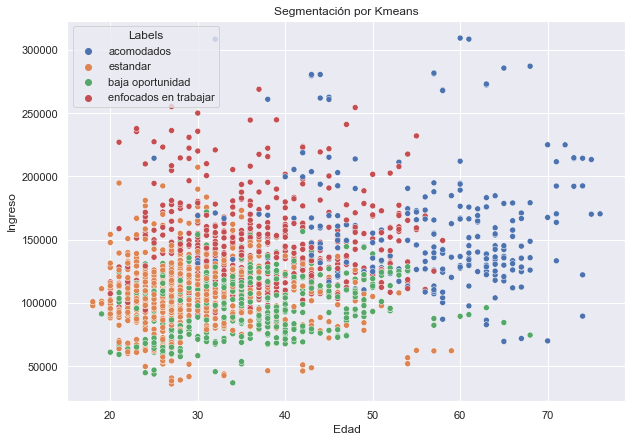

In [23]:
# x = df_analisis["Age"].to_numpy()
# y = df_analisis["Income"].to_numpy()
plt.figure(figsize = (10,7))
plt.title("Segmentación por Kmeans")
plt.xlabel("Edad")
plt.ylabel("Ingreso")
sns.scatterplot(data=df_analisis, x = "Age", y = "Income",
               hue = df_analisis["Labels"])

plt.show()

Del gráfico anterior podemos ver que el segmento de *acomodados* esta bastante bien separado, no obstante los otros tres están bastante juntos.

Intentaremos mejorar esta separación utilizando PCA.

## Principal Component Analysis

En el ámbito del procesamiento de señales, como así también en el análisis de datos o en ML, el PCA es un método algebráico para reducir la dimensionalidad de un espacio vectorial.

Técnicamente, lo que PCA hace es una transformación lineal de los datos en un nuevo espacio. Los ejes de este nuevo espacio corresponden a las proyecciones de los datos originales y son ortogonales, lo que implica que son linealmente independientes y por lo tanto, no están correlacionados.

Estas nuevas proyecciones poseen un orden, el primer eje de coordenadas, proyección o *componente principal* es aquel que posee la mayor varianza de los datos originales, la segunda varianza más grande se encuentra en el segundo eje, y así sucesivamente.

Por lo tanto, cada componente (o eje del nuevo sistema de coordenadas) posee información del sistema orginal. A medida que agregamos compoentens, obtenemos mayor información. Lo interesante es que podríamos elegir una cantidad de componentes menor a la que posee el sistema original, y aún así tendríamos suficiente información para trabajar de nuestro set.

Apliquemos PCA a los datos que tenemos ahora.

Utilizaremos la clase [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) de Scikit-learn.

In [24]:
pca = PCA()

In [25]:
#Entrenamos la instancia PCA usando los datos estandarizados.
pca.fit(df_std)

PCA()

La variable *[explained_variance_ratio_]()* nos da la varianza correspondiente a cada componente, según la documentación,

> Percentage of variance explained by each of the selected components. If n_components is not set then all components are stored and the sum of the ratios is equal to 1.0.

In [26]:
pca.explained_variance_ratio_

array([0.35696328, 0.26250923, 0.18821114, 0.0755775 , 0.05716512,
       0.03954794, 0.02002579])

Podemos ver que solo con las tres primeras coordenadas tenemos casi el 81% de la varianza de nuestros datos.

In [27]:
sum(pca.explained_variance_ratio_[:3])

0.8076836525675645

Grafiquemos la cantidad de componentes que tenemos (originalmente son 7) vs la variable *explained_variance_ratio_*.

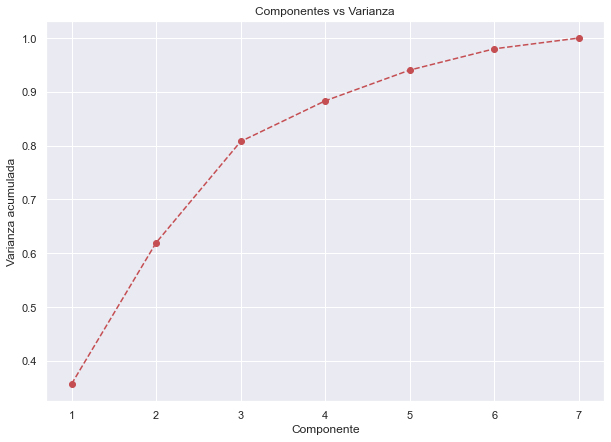

In [28]:
fig, ax = plt.subplots(figsize = (10,7))

ax.set_title("Componentes vs Varianza")
ax.set_xlabel("Componente")
ax.set_ylabel("Varianza acumulada")
ax.plot(range(1,8), pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '--', color = "r")

plt.show()

La regla dice que es bueno elegir una cantidad de componentes de tal forma que acumulen entre el 70% al 80% de la variabilidad de mis datos.

En este caso, tomando 3 componentes tenemos el 80%.

In [29]:
pca = PCA(n_components = 3)
pca.fit(df_std)

PCA(n_components=3)

In [30]:
pca.components_.shape

(3, 7)

Los 3 componentes principales elegidos forman una matriz de $3\times7$, lo cual tiene sentido ya que nuestros datos originales poseen 7 features.

Los valores dentro de esta matriz se llaman *loadings*. Estos representan la *correlación entre los datos originales y los componentes dentro del nuevo espacio*.

Por ejemplo, el primer valor del segundo renglón representa la carga o *loading* de la primer característica o feature y el segundo componente.

In [31]:
print(pca.components_[1,0])

pca.components_

0.45800607952048455


array([[-0.31469524, -0.19170439,  0.32609979,  0.15684089,  0.52452463,
         0.49205868,  0.46478852],
       [ 0.45800608,  0.51263492,  0.31220793,  0.63980683,  0.12468314,
         0.01465779, -0.06963165],
       [-0.29301261, -0.44197739,  0.60954372,  0.27560461, -0.16566231,
        -0.39550539, -0.29568503]])

Vamos a mejorar esta representación a través de un dataframe, de tal manera de poder ver los valores de correlación de cada componente con cada feature dentro de nuestro set de datos.

In [32]:
df_pca = pd.DataFrame(pca.components_, columns = df.columns.values,
                     index = ["Componente 1", "Componente 2", "Componente 3"])

In [33]:
df_pca

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
Componente 1,-0.314695,-0.191704,0.326100,0.156841,0.524525,0.492059,0.464789
Componente 2,0.458006,0.512635,0.312208,0.639807,0.124683,0.014658,-0.069632
Componente 3,-0.293013,-0.441977,0.609544,0.275605,-0.165662,-0.395505,-0.295685


Grafiquemos un mapa de calor para comparar estas correlaciones.

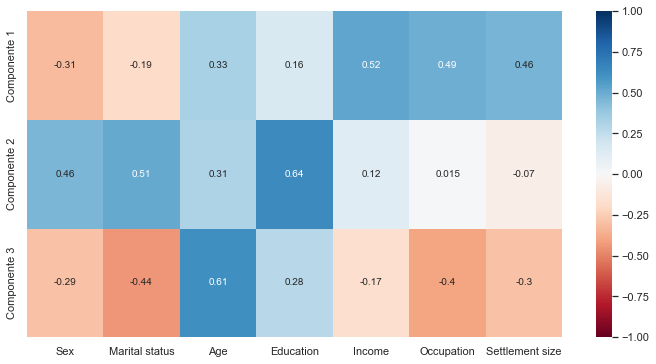

In [34]:
fig, ax = plt.subplots(figsize = (12,6))
sns.heatmap(df_pca, vmin = -1, vmax = 1, cmap = "RdBu", annot = True)
# ax.set_yticks([0,1,2], ["Componente 1", "Componente 2", "Componente 3"],
#              rotation = 90,
#              fontsize = 9)

plt.show()

#### Analizando cada componente

- **Componente 1 - Nivel en Profesión**: Vemos que tenemos correlaciones positivas entre las features Edad, Educación (baja), Ingreso, Ocupación y lugar de asentamiento. Por lo tanto, podemos concluir que este componente nos da información de cuán enfocada en su trabajo esta.
- **Componente 2 - Nivel educativo, estilo de vida**: Vemos una fuerte correlación en las variables Sexo, Estado civil y Educación, y algo menos en edad. Pero vemos muy poca correlación en ingreso, ocupación y asentamiento. Por lo tanto, podemos decir que este componente nos da información acerca del nivel educativo de la persona y del estilo de vida del individuo, pero no de su carrera profesional.
- **Componente 3 - Experimentados**: Podemos ver una fuerta correlación positiva en sexo, y dos correlaciones negativas en estado civil y ocupación. Esto es interesante, ya que nos dice que personas mayores no necesariamente tienen experiencia laboral o experiencia de vida.

Ahora bien, debemos transformar el espacio original al nuevo espacio dado por el PCA.

Entonces,

In [35]:
df_pca_transformed = pca.transform(df_std)

In [36]:
df_pca_transformed.shape

(2000, 3)

Podemos ver que *df_pca_transformed* es de $2000\times3$, cada columna ahora representa la proyección de los datos del espacio original en el espacio de las tres componentes principales que hemos seleccionado.

### Clustering usando PCA

In [37]:
wcss = []

for i in range(1,11):
    kmeans_pca = KMeans(n_clusters = i, init = "k-means++", random_state = 42)
    kmeans_pca.fit(df_pca_transformed)
    wcss.append(kmeans_pca.inertia_)

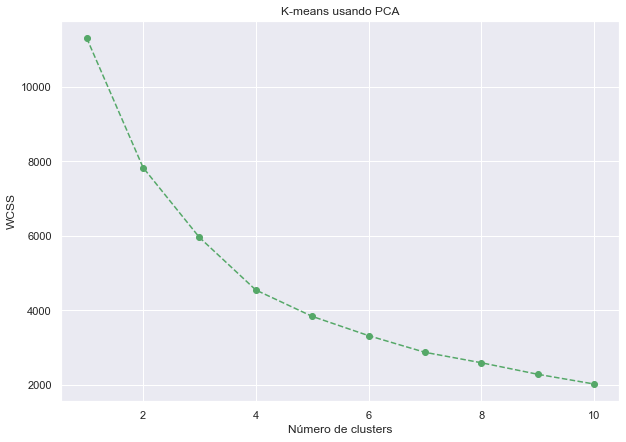

In [38]:
plt.figure(figsize = (10,7))
plt.xlabel("Número de clusters")
plt.ylabel("WCSS")
plt.title("K-means usando PCA")
plt.plot(range(1,11), wcss, marker = "o", linestyle = "--", color = "g")

plt.show()

Al igual que antes, podemos elegir 4 clusters.

In [39]:
kmeans_pca = KMeans(n_clusters = 4, init = "k-means++", random_state = 42)
kmeans_pca.fit(df_pca_transformed)

KMeans(n_clusters=4, random_state=42)

### Analizando los clusters con PCA

In [40]:
df_segmentado_pca = pd.concat([df.reset_index(drop = True), pd.DataFrame(df_pca_transformed)], axis = 1)
df_segmentado_pca.columns.values[7:] = ["Componente 1", "Componente 2", "Componente 3"]
df_segmentado_pca["Segmentos KMeans - PCA"] = kmeans_pca.labels_

In [41]:
df_segmentado_pca

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Componente 1,Componente 2,Componente 3,Segmentos KMeans - PCA
0,0,0,67,2,124670,1,2,2.514746,0.834122,2.174806,3
1,1,1,22,1,150773,1,2,0.344935,0.598146,-2.211603,0
2,0,0,49,1,89210,0,0,-0.651063,-0.680093,2.280419,2
3,0,0,45,1,171565,1,1,1.714316,-0.579927,0.730731,1
4,0,0,53,1,149031,1,1,1.626745,-0.440496,1.244909,1
...,...,...,...,...,...,...,...,...,...,...,...
1995,1,0,47,1,123525,0,0,-0.866034,0.298330,1.438958,2
1996,1,1,27,1,117744,1,0,-1.114957,0.794727,-1.079871,0
1997,0,0,31,0,86400,0,0,-1.452298,-2.235937,0.896571,2
1998,1,1,24,1,97968,0,0,-2.241453,0.627108,-0.530456,0


##### Nombrando segmentos

Ahora, vamos a analizar este nuevo dataframe para encontrar los segmentos en base a las tres nuevas componentes que hemos encontrado usando PCA.

In [42]:
df_segmentado_pca_resumen = df_segmentado_pca.groupby(["Segmentos KMeans - PCA"]).mean()
df_segmentado_pca_resumen

# df_segmentado_pca_resumen.iloc[:,6:]

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Componente 1,Componente 2,Componente 3
Segmentos KMeans - PCA,,,,,,,,,,
0,0.900289,0.965318,28.878613,1.060694,107551.500000,0.677746,0.440751,-1.107019,0.703776,-0.781410
1,0.027444,0.168096,35.737564,0.734134,141525.826758,1.267581,1.480274,1.372663,-1.046172,-0.248046
2,0.306522,0.095652,35.313043,0.760870,93692.567391,0.252174,0.039130,-1.046406,-0.902963,1.003644
3,0.505660,0.690566,55.679245,2.128302,158019.101887,1.120755,1.101887,1.687328,2.031200,0.844039


#### Nombrando segmentos en base a las componentes principales

El agrupamiento de *Segmentos KMeans - PCA* de este dataframe es diferente al que analizamos anteriormente para segmentar a los clientes.

Aquí debemos prestar especial atención a lo que representan cada una de las tres componentes que hemos seleccionado.

Las tres últimas columnas de la tabla de arriba nos dan información **cualitativa** acerca de los clusters que KMeans ha formado.

Analicemos estos datos.

---

Recordemos qué las CP (componentes principales) son:

    CP1: Nivel en profesión.
    CP2: Nivel educativo, estilo de vida.
    CP3: Experimentados.


- **Grupo 0 - Estándar**: En este caso vemos bajo nivel en profesión y bajo nivel de experiencia o edad, y al mismo tiempo, un nivel moderado a alto de educación y estilo de vida. Podemos decir que es el grupo Estándard.
- **Grupo 1 - Enfocados en trabajar**: Para este grupo vemos que la CP1 es alta, mientras que la CP2 es baja, y la CP3 es cercana a cero en comparación con el resto, lo cual nos lleva a decir que de alguna manera es un público joven o de poca experiencia. Pero por otro lado, el nivel profesional es elevado, por lo que podemos decir que es el grupo correspondiente a "Enfocados en Trabajar". 
- **Grupo 2 - Baja Oportunidad**: En este grupo vemos que las componentes CP1 y CP2 son bajas, mientras que CP3 es alta. Es decir, son personas que evidentemente no tienen buenos trabajos, no están en asentamientos grandes y el nivel educativo no es muy alto. Por lo tanto, podemos decir que es el grupo de Baja Oportunidad.
- **Grupo 3 - Acomodados**: Analizando los valores medios de las tres componentes para el cluster 2, vemos que los valores de CP1, CP2 y CP3 son altos en comparación al resto, por lo tanto, podemos decir que este nivel es el de personas acomodadas.

Veamos la cantidad de personas y las proporciones dentro de cada cluster.

In [43]:
df_segmentado_pca_resumen["N Obs"] = df_segmentado_pca[["Segmentos KMeans - PCA","Sex"]].groupby("Segmentos KMeans - PCA").count()
df_segmentado_pca_resumen["Proporciones"] = df_segmentado_pca_resumen["N Obs"]/df_segmentado_pca_resumen["N Obs"].sum()
df_segmentado_pca_resumen = df_segmentado_pca_resumen.rename({0: "Estándar",
                                                              1: "Enfocados en trabajar",
                                                              2: "Baja oportunidad",
                                                              3: "Acomodados"})

In [44]:
df_segmentado_pca_resumen

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Componente 1,Componente 2,Componente 3,N Obs,Proporciones
Segmentos KMeans - PCA,,,,,,,,,,,,
Estándar,0.900289,0.965318,28.878613,1.060694,107551.500000,0.677746,0.440751,-1.107019,0.703776,-0.781410,692,0.3460
Enfocados en trabajar,0.027444,0.168096,35.737564,0.734134,141525.826758,1.267581,1.480274,1.372663,-1.046172,-0.248046,583,0.2915
Baja oportunidad,0.306522,0.095652,35.313043,0.760870,93692.567391,0.252174,0.039130,-1.046406,-0.902963,1.003644,460,0.2300
Acomodados,0.505660,0.690566,55.679245,2.128302,158019.101887,1.120755,1.101887,1.687328,2.031200,0.844039,265,0.1325


Nuetro análisis sin PCA nos daba.

In [45]:
df_segmentado

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,N Obs,Proporciones
Segmentos por kmeans,,,,,,,,,
acomodados,0.501901,0.692015,55.703422,2.129278,158338.422053,1.129278,1.110266,263,0.1315
baja oportunidad,0.352814,0.019481,35.577922,0.746753,97859.852814,0.329004,0.043290,462,0.2310
estandar,0.853901,0.997163,28.963121,1.068085,105759.119149,0.634043,0.422695,705,0.3525
enfocados en trabajar,0.029825,0.173684,35.635088,0.733333,141218.249123,1.271930,1.522807,570,0.2850


Vemos algunas diferencias entre la segmentación entre los cluster con y sin PCA.

#### Visualizando componentes

Vamos a hacer un scatterplot con las CP1 y CP2.

In [46]:
df_segmentado_pca["Labels"] = df_segmentado_pca["Segmentos KMeans - PCA"].map({0: "Estándar",
                                                                              1: "Enfocados en trabajar",
                                                                              2: "Baja oportunidad",
                                                                              3: "Acomodados"})

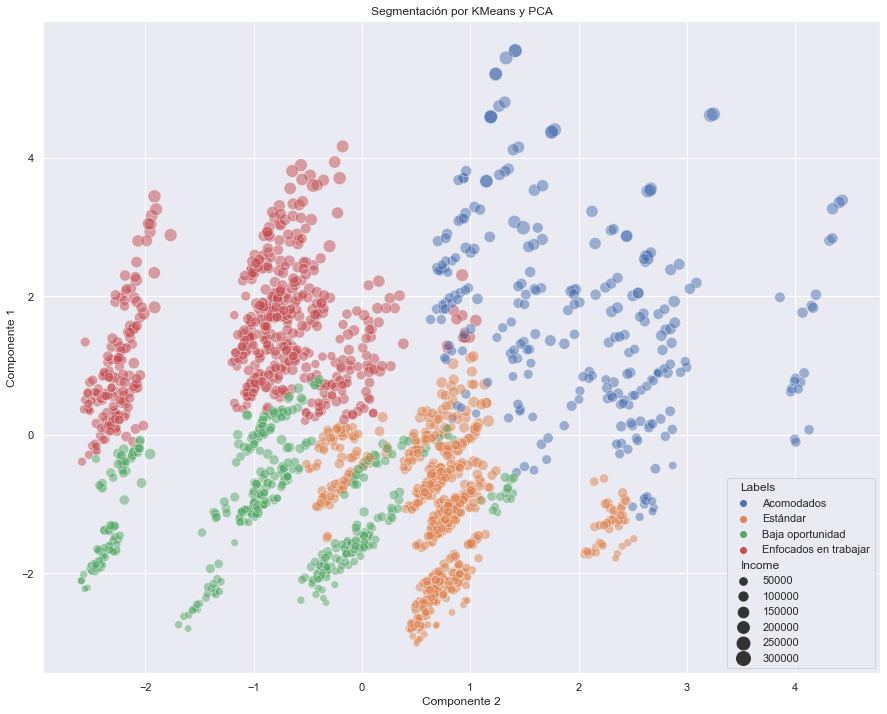

In [47]:
plt.figure(figsize = (15,12))

x = df_segmentado_pca["Componente 1"]
y = df_segmentado_pca["Componente 2"]

sns.scatterplot(data = df_segmentado_pca, x = "Componente 2", y = "Componente 1", hue = df_segmentado_pca["Labels"],
               size = df_segmentado_pca['Income'], sizes = (50,200), alpha = 0.5)

plt.title("Segmentación por KMeans y PCA")

plt.show()

#### Análisis del scatterplot

Con la aplicación de PCA podemos tener una mejor separación de cada segmento. De todos modos, en algunos casos hay solapamiento, pero en mucho menor medida que el análisis sin PCA. Para poder ver estos grupos mejor separados, deberíamos graficar una componente adicional (scatter en 3D) o más de una, lo cual haría imposilbe una graficación. Pero desde el punto de vista matemático, los puntos podrían separarse mejor al ir agregando *ejes* nuevos.

En este caso en particular, hemos obtenido un buen resultado. Una de las razones principales es que tenemos pocas features en nuestro set de datos original. En los casos donde tengamos mayor cantidad de features, el PCA sigue siendo sumamente útil para reducir la dimensionalidad de mis datos, pero a veces no es psoible visualizar tan nítidamente como este ejemplo ya que estamos limitados a ver las cosas, como mucho, en 3D.

### Guardando modelo

Vamos a utilizar [pickle](https://docs.python.org/3/library/pickle.html) para guardar los modelos y algunos valores que hemos generado en este apartado. 

Utilizaremos estos archivos en un futuro.

In [48]:
## guardamos el objeto "StandardScaler"
pickle.dump(scaler, open("models/scaler.pickle", "wb"))

## guardamos los modelos PCA y KMeans que hemos generado.
## Esto es importante ya que en un futuro queremos utilizar 
## los mismos criterios de selección en nuevos datos.
pickle.dump(pca, open("models/pca.pickle", "wb"))
pickle.dump(kmeans_pca, open("models/kmeans_pca.pickle", "wb"))

### Comentarios finales

Hemos utilizado KMeans y PCA para poder segmentar los datos. Lo interesante de usar PCA es que nos permite reducir la dimensionalidad de nuestros datos. Esto es siempre una ventaja, sobre todo cuando necesitamos separar o segmentar datos y también cuando generamos *features* a partir de los mismos.

Finalmente, hemos exportado los modelos (objetos) a formato string usando *pickle*. Esto último nos permitirá cargar los modelos con los parámetros entrenados ahora. Es una práctica muy habitual.

Utilizaremos la segmentación de clientes para inferir cuestiones como probabilidad de compra de cierto producto considerando cambios en el precio de dicho producto y también cambios en el preico de marcas competidoras.